## Challenge Data Engineer

**Nombre:Ricardo F. Zúñiga Antiñirre**

**Fecha Entrega:21-01-2023:18:00**

## 1. Procesos automatizados para ingerir y almacenar los datos bajo demanda

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
from matplotlib import pyplot as plt
import sqlite3
from os import remove
import seaborn as sns
import conexion
import datetime
import random
import string
import time




In [113]:
#!pip install ipython-sql  

In [4]:
%load_ext sql

### Creación BBDD SQLite

In [5]:
%sql sqlite:///foo.db

In [68]:
%%sql
drop table if exists trips

 * sqlite:///foo.db
Done.


[]

### Creación tabla trips

In [69]:
%%sql
create table trips(region varchar(20),origin_coord varchar(50),destination_coord varchar (50),datetime varchar(20),datasource varchar(20))

 * sqlite:///foo.db
Done.


[]

In [8]:
%%sql
select * from trips

 * sqlite:///foo.db
Done.


region,origin_coord,destination_coord,datetime,datasource


## Proceso automatizado de ingesta de información utilizando Socket

### servidor Socket

**Se crea un servidor de socket:**

server.py

**Se ejecuta a través de consola:**

python server.py


C:\Users\Usuario\Documents\POSTULACIONES\NeuralNetwork>python server.py

Socket successfully created

socket binded to 12345

socket is listening

### Cliente Socket


Se utiliza el cliente connect,py.

La conexion cliente se realiza a través e la función init_socket()

El servidor constantemente se encuentra preguntando si existe algun archivo en el bucket de entrada, retornando TRUE o FALSE


In [9]:
conexion.init_socket()

TRUE


### Proceso de carga de datos

In [10]:
data = pd.read_csv("trips.csv", delimiter=",", encoding="ascii")

In [11]:
data.head()

,region,origin_coord,destination_coord,datetime,datasource
0,Prague,POINT (14.4973794438195 50.00136875782316),POINT (14.43109483523328 50.04052930943246),2018-05-28 09:03:40,funny_car
1,Prague,POINT (14.4973794438195 50.00136875782316),POINT (14.43109483523328 50.04052930943246),2018-05-28 09:03:40,funny_car
2,Turin,POINT (7.672837913286881 44.9957109242058),POINT (7.720368637535126 45.06782385393849),2018-05-21 02:54:04,baba_car
3,Prague,POINT (14.32427345662177 50.00002074358429),POINT (14.47767895969969 50.09339790740321),2018-05-13 08:52:25,cheap_mobile
4,Turin,POINT (7.541509189114433 45.09160503827746),POINT (7.74528653441973 45.02628598341506),2018-05-06 09:49:16,bad_diesel_vehicles


### Análisis descriptivo

In [12]:
data.dtypes

region               object
origin_coord         object
destination_coord    object
datetime             object
datasource           object
dtype: object

In [13]:
data.isnull().sum()

region               0
origin_coord         0
destination_coord    0
datetime             0
datasource           0
dtype: int64

**no existen elementos nulos**

### Función ingesta de datos

In [70]:
def insertVaribleIntoTable(region, origin_coord, destination_coord, datetime, datasource,flag):
    try:
        sqliteConnection = sqlite3.connect('foo.db')
        cursor = sqliteConnection.cursor()
        #print("Connected to SQLite")
        
        
        if flag==0:
            sqlite_insert_with_param = """INSERT INTO trips
                              (region, origin_coord	, destination_coord, datetime, datasource) 
                              VALUES (?, ?, ?, ?, ?);"""
        
        if flag==1:
            sqlite_insert_with_param = """INSERT INTO trips_test
                              (region, origin_coord	, destination_coord, datetime, datasource) 
                              VALUES (?, ?, ?, ?, ?);"""        

        data_tuple = (region, origin_coord, destination_coord, datetime, datasource)
        cursor.execute(sqlite_insert_with_param, data_tuple)
        sqliteConnection.commit()
        #print("Python Variables inserted successfully into SqliteDb_developers table")

        cursor.close()

    except sqlite3.Error as error:
        print("Failed to insert Python variable into sqlite table", error)
    finally:
        if sqliteConnection:
            sqliteConnection.close()
            #print("The SQLite connection is closed")

### a.-Los viajes que son similares en términos de origen, destino y hora del día deben agruparse. Describa el enfoque que utilizó para agregar viajes similares

**Se utiliza el método pandas.DataFrame.groupby, es necesario indicar el eje que contiene el criterio por el que se va a realizar la agrupación.**

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html



**Como ejemplo, a continuación se repitió la primera fila del .csv original, antes de la agg muestra 101 datos, posterior a la agg agrupa en 100** 

In [16]:
data_agrupada =data.groupby(["origin_coord","destination_coord","datetime"])

In [17]:
len(data)

101

In [18]:
len(data_agrupada)

100

In [19]:
print(type(data))
print(type(data_agrupada))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.groupby.generic.DataFrameGroupBy'>


In [20]:
data_agrupada =pd.DataFrame(data_agrupada.head(len(data_agrupada)))

In [21]:
data_agrupada.head(len(data_agrupada))

,region,origin_coord,destination_coord,datetime,datasource
0,Prague,POINT (14.4973794438195 50.00136875782316),POINT (14.43109483523328 50.04052930943246),2018-05-28 09:03:40,funny_car
1,Prague,POINT (14.4973794438195 50.00136875782316),POINT (14.43109483523328 50.04052930943246),2018-05-28 09:03:40,funny_car
2,Turin,POINT (7.672837913286881 44.9957109242058),POINT (7.720368637535126 45.06782385393849),2018-05-21 02:54:04,baba_car
3,Prague,POINT (14.32427345662177 50.00002074358429),POINT (14.47767895969969 50.09339790740321),2018-05-13 08:52:25,cheap_mobile
4,Turin,POINT (7.541509189114433 45.09160503827746),POINT (7.74528653441973 45.02628598341506),2018-05-06 09:49:16,bad_diesel_vehicles
...,...,...,...,...,...
96,Prague,POINT (14.33562319852013 50.05977285737693),POINT (14.45302412886982 50.06961029075634),2018-05-03 18:56:45,cheap_mobile
97,Hamburg,POINT (9.996714798980491 53.52203690589671),POINT (10.17431393081631 53.51796499041119),2018-05-23 12:43:17,baba_car
98,Prague,POINT (14.40975521275597 50.037791514028),POINT (14.59895464921585 50.05472087955579),2018-05-12 08:13:09,cheap_mobile
99,Hamburg,POINT (10.08338857045871 53.59661344302611),POINT (10.17914017806172 53.60909301795856),2018-05-22 10:39:49,baba_car


### Proceso inserción de datos tabla SQLite

In [71]:
for i in range(len(data_agrupada)):
    insertVaribleIntoTable(str(data_agrupada.iloc[i]['region']),str(data_agrupada.iloc[i]['origin_coord']),str(data_agrupada.iloc[i]['destination_coord']),str(data_agrupada.iloc[i]['datetime']),str(data_agrupada.iloc[i]['datasource']),0)


In [23]:
%%sql
select * from trips

 * sqlite:///foo.db
Done.


region,origin_coord,destination_coord,datetime,datasource
Prague,POINT (14.4973794438195 50.00136875782316),POINT (14.43109483523328 50.04052930943246),2018-05-28 09:03:40,funny_car
Prague,POINT (14.4973794438195 50.00136875782316),POINT (14.43109483523328 50.04052930943246),2018-05-28 09:03:40,funny_car
Turin,POINT (7.672837913286881 44.9957109242058),POINT (7.720368637535126 45.06782385393849),2018-05-21 02:54:04,baba_car
Prague,POINT (14.32427345662177 50.00002074358429),POINT (14.47767895969969 50.09339790740321),2018-05-13 08:52:25,cheap_mobile
Turin,POINT (7.541509189114433 45.09160503827746),POINT (7.74528653441973 45.02628598341506),2018-05-06 09:49:16,bad_diesel_vehicles
Turin,POINT (7.614078119815749 45.13433106465422),POINT (7.527497142312585 45.03335051325654),2018-05-23 12:45:54,pt_search_app
Hamburg,POINT (10.07299025213017 53.62044974829032),POINT (9.789197601249002 53.46315765148751),2018-05-15 09:13:36,bad_diesel_vehicles
Hamburg,POINT (9.910278201788232 53.58386264717827),POINT (10.02557919725378 53.4120717767391),2018-05-13 13:09:19,funny_car
Turin,POINT (7.560785081962462 45.01901608530191),POINT (7.583568695710608 45.10526898076209),2018-05-06 00:00:44,cheap_mobile
Turin,POINT (7.702418079996892 45.05754972796922),POINT (7.623229346744799 44.99969774086024),2018-05-14 02:07:30,cheap_mobile


## 2. Un servicio que es capaz de proporcionar la siguiente funcionalidad.

### a.-Devuelve el promedio semanal de la cantidad de viajes para un área definida por un bounding box y la región

**Instalacion de librerias trabajar con geocode**

In [319]:
!pip -q install nltk folium opencv-python opencv-contrib-python 

In [352]:
!pip -q install geopy

**se define nombre del agente para geolocator**

In [24]:
from geopy.geocoders import Nominatim 
geolocator = Nominatim(user_agent="app_geolocation")

**La funcion geocode retorna información de la región**

In [25]:
location = geolocator.geocode("Prague") 
print(location.address)

Praha, Hlavní město Praha, Praha, Česko


In [26]:
print(location.raw)

{'place_id': 298175117, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 439840, 'boundingbox': ['49.9419006', '50.1774301', '14.2244355', '14.7067867'], 'lat': '50.0596288', 'lon': '14.446459273258009', 'display_name': 'Praha, Hlavní město Praha, Praha, Česko', 'class': 'boundary', 'type': 'administrative', 'importance': 0.7434914632787466, 'icon': 'https://nominatim.openstreetmap.org/ui/mapicons/poi_boundary_administrative.p.20.png'}


**Se recorre el diccionario para acceder al boundingbox de la región**

In [27]:
dic_aux={}
dic_aux=location.raw

for clave in dic_aux["boundingbox"]:
    print(clave)


49.9419006
50.1774301
14.2244355
14.7067867


In [28]:
print((location.latitude, location.longitude))

(50.0596288, 14.446459273258009)


**Con la libreria folium podemos visualizar el área en estudio**

In [74]:
import folium

In [76]:
m = folium.Map(location=[location.latitude, location.longitude])
m

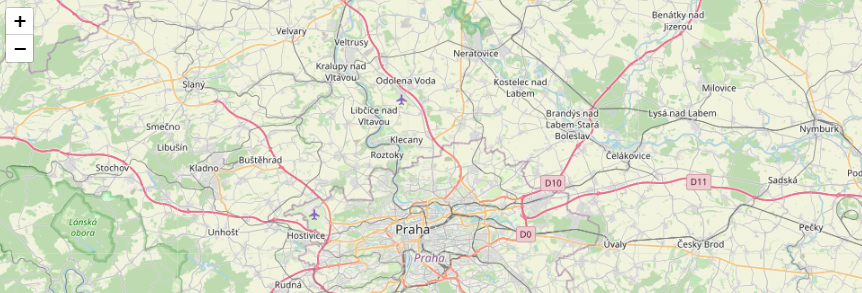

In [32]:
data_agrupada.head()

,region,origin_coord,destination_coord,datetime,datasource
0,Prague,POINT (14.4973794438195 50.00136875782316),POINT (14.43109483523328 50.04052930943246),2018-05-28 09:03:40,funny_car
1,Prague,POINT (14.4973794438195 50.00136875782316),POINT (14.43109483523328 50.04052930943246),2018-05-28 09:03:40,funny_car
2,Turin,POINT (7.672837913286881 44.9957109242058),POINT (7.720368637535126 45.06782385393849),2018-05-21 02:54:04,baba_car
3,Prague,POINT (14.32427345662177 50.00002074358429),POINT (14.47767895969969 50.09339790740321),2018-05-13 08:52:25,cheap_mobile
4,Turin,POINT (7.541509189114433 45.09160503827746),POINT (7.74528653441973 45.02628598341506),2018-05-06 09:49:16,bad_diesel_vehicles


### Servicio que retorna el promedio semanal

**Primero encontrar los datos de la region**


In [33]:
location = geolocator.geocode("Prague") 
print(location.address)

print(location.raw)

dic_aux={}
dic_aux=location.raw

for clave in dic_aux["boundingbox"]:
    print(clave)

Praha, Hlavní město Praha, Praha, Česko
{'place_id': 298175117, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 439840, 'boundingbox': ['49.9419006', '50.1774301', '14.2244355', '14.7067867'], 'lat': '50.0596288', 'lon': '14.446459273258009', 'display_name': 'Praha, Hlavní město Praha, Praha, Česko', 'class': 'boundary', 'type': 'administrative', 'importance': 0.7434914632787466, 'icon': 'https://nominatim.openstreetmap.org/ui/mapicons/poi_boundary_administrative.p.20.png'}
49.9419006
50.1774301
14.2244355
14.7067867


**Filtrar data por región**

In [34]:
#data_filter.to_string(index=False)
data_filter = data_agrupada[data_agrupada['region'] == "Prague"]
#data_filter=data_filter.style.hide_index()


#data_filter.index(inplace=False)
data_filter

,region,origin_coord,destination_coord,datetime,datasource
0,Prague,POINT (14.4973794438195 50.00136875782316),POINT (14.43109483523328 50.04052930943246),2018-05-28 09:03:40,funny_car
1,Prague,POINT (14.4973794438195 50.00136875782316),POINT (14.43109483523328 50.04052930943246),2018-05-28 09:03:40,funny_car
3,Prague,POINT (14.32427345662177 50.00002074358429),POINT (14.47767895969969 50.09339790740321),2018-05-13 08:52:25,cheap_mobile
14,Prague,POINT (14.34394689715277 50.12299688052901),POINT (14.45046952210687 50.10077692162883),2018-05-20 02:31:22,cheap_mobile
16,Prague,POINT (14.49290671173996 50.01644032542101),POINT (14.48735724430722 50.0275445326544),2018-05-01 11:50:58,cheap_mobile
18,Prague,POINT (14.41986637983827 50.02012470664376),POINT (14.41014860957387 50.08518970681641),2018-05-06 12:56:14,bad_diesel_vehicles
22,Prague,POINT (14.42559620999022 50.05308939656821),POINT (14.54762887318999 50.00573858824717),2018-05-11 21:16:54,baba_car
27,Prague,POINT (14.65848565403607 50.11571340810843),POINT (14.61296534823862 50.06347771442317),2018-05-08 04:22:01,funny_car
28,Prague,POINT (14.35146190337486 50.10386689948413),POINT (14.3588281620048 50.00428816034508),2018-05-21 06:52:19,bad_diesel_vehicles
30,Prague,POINT (14.4251434102725 50.08626745067269),POINT (14.40585085170846 50.09331773424552),2018-05-02 13:48:30,baba_car


In [35]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="app_geolocation") 

def geo_search(region, coordenadas):
    
    flag=0

    location = geolocator.geocode(region) 
    location = geolocator.reverse(coordenadas)
      
    flag=0 
    if location is not None:
        if len(location)>0:
            flag=1
        else:
            flag=0
    
    return flag

    
    #print(location.address)
    


**conversión columna a tipo datetime**

In [37]:
data_filter['datetime'] = pd.to_datetime(data_filter['datetime'])

C:\Users\Usuario\anaconda3\envs\MOD6-MINI3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
data_filter.dtypes

region                       object
origin_coord                 object
destination_coord            object
datetime             datetime64[ns]
datasource                   object
dtype: object

**método de agrupamiento semanal**

In [39]:
grouper = pd.Grouper(key='datetime',freq='W-MON')
data_filter["week"] = data_filter.groupby(grouper).grouper.group_info[0] + 1

C:\Users\Usuario\anaconda3\envs\MOD6-MINI3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Búsqueda del promedio semanal**

In [40]:
data_filter

,region,origin_coord,destination_coord,datetime,datasource,week
0,Prague,POINT (14.4973794438195 50.00136875782316),POINT (14.43109483523328 50.04052930943246),2018-05-28 09:03:40,funny_car,1
1,Prague,POINT (14.4973794438195 50.00136875782316),POINT (14.43109483523328 50.04052930943246),2018-05-28 09:03:40,funny_car,1
3,Prague,POINT (14.32427345662177 50.00002074358429),POINT (14.47767895969969 50.09339790740321),2018-05-13 08:52:25,cheap_mobile,1
14,Prague,POINT (14.34394689715277 50.12299688052901),POINT (14.45046952210687 50.10077692162883),2018-05-20 02:31:22,cheap_mobile,1
16,Prague,POINT (14.49290671173996 50.01644032542101),POINT (14.48735724430722 50.0275445326544),2018-05-01 11:50:58,cheap_mobile,1
18,Prague,POINT (14.41986637983827 50.02012470664376),POINT (14.41014860957387 50.08518970681641),2018-05-06 12:56:14,bad_diesel_vehicles,1
22,Prague,POINT (14.42559620999022 50.05308939656821),POINT (14.54762887318999 50.00573858824717),2018-05-11 21:16:54,baba_car,1
27,Prague,POINT (14.65848565403607 50.11571340810843),POINT (14.61296534823862 50.06347771442317),2018-05-08 04:22:01,funny_car,1
28,Prague,POINT (14.35146190337486 50.10386689948413),POINT (14.3588281620048 50.00428816034508),2018-05-21 06:52:19,bad_diesel_vehicles,1
30,Prague,POINT (14.4251434102725 50.08626745067269),POINT (14.40585085170846 50.09331773424552),2018-05-02 13:48:30,baba_car,1


### En esta parte con la funcion geo_search, validamos que las coordenadas tanto de origen y destino pertenezcan a la ruta dentro de la region (el total nos servirá para obtener el promedio de viajes semanales).

**La funcion geo_search retorna [0,1] si las coordenadas se encuetran en el boundingbox de la region**

In [41]:
cantidad_total_viajes=0
cantidad_no_pertenece_region=0
for semana, datos in data_filter.groupby("week"):
    #origin_coord=datos["origin_coord"].to_string(index = False)
    orig_coord_data={}
    orig_coord_data=datos["origin_coord"].values
    
    for i in orig_coord_data:
        origin_coord=i
        origin_coord = origin_coord.replace("POINT (", "")
        origin_coord = origin_coord.replace(")", "")
        origin_coord=origin_coord.replace(" ", ",")
        flag=geo_search("Prague",origin_coord)
        if flag==1:
            cantidad_total_viajes=cantidad_total_viajes+1
        else:
            cantidad_no_pertenece_region=cantidad_no_pertenece_region+1
            

    dest_coord_data={}
    dest_coord_data=datos["destination_coord"].values

    for i in dest_coord_data:
        dest_coord=i
        dest_coord = dest_coord.replace("POINT (", "")
        dest_coord = dest_coord.replace(")", "")
        dest_coord=dest_coord.replace(" ",",") 
        flag=geo_search("Prague",dest_coord)
        if flag==1:
            cantidad_total_viajes=cantidad_total_viajes+1
        else:
            cantidad_no_pertenece_region=cantidad_no_pertenece_region+1
print("cantidad total de viajes:",cantidad_total_viajes)
print("cantidad total de viajes no pertenece region:",cantidad_no_pertenece_region)


cantidad total de viajes: 10
cantidad total de viajes no pertenece region: 60


**pd:Tras ejecutar la funcion geo_search, podemos apreciar que existen 60 coordenadas que no pertenecen a la región**

### Cálculo promedio semanal de la cantidad de viajes

In [42]:
cont=0
for semana, datos in data_filter.groupby("week"):
    #origin_coord=datos["origin_coord"].to_string(index = False)
    orig_coord_data={}
    orig_coord_data=datos["origin_coord"].values
    
    for i in orig_coord_data:
        origin_coord=i
        origin_coord = origin_coord.replace("POINT (", "")
        origin_coord = origin_coord.replace(")", "")
        origin_coord=origin_coord.replace(" ", ",")

    dest_coord_data={}
    dest_coord_data=datos["destination_coord"].values

    for i in dest_coord_data:
        dest_coord=i
        dest_coord = dest_coord.replace("POINT (", "")
        dest_coord = dest_coord.replace(")", "")
        dest_coord=dest_coord.replace(" ",",") 

    inicio = datos.iloc[0].datetime
    fin = datos.iloc[-1].datetime
    print("La semana {} tiene {} viajes, que van de {} ({}) a {} ({}),promedio semanal es:{}".format(semana, len(datos), inicio.date(), inicio.day_name(), fin.date(), fin.day_name(),cantidad_total_viajes/len(datos)))

La semana 1 tiene 10 viajes, que van de 2018-05-28 (Monday) a 2018-05-02 (Wednesday),promedio semanal es:1.0
La semana 2 tiene 9 viajes, que van de 2018-05-06 (Sunday) a 2018-05-29 (Tuesday),promedio semanal es:1.1111111111111112
La semana 3 tiene 8 viajes, que van de 2018-05-20 (Sunday) a 2018-05-14 (Monday),promedio semanal es:1.25
La semana 4 tiene 6 viajes, que van de 2018-05-23 (Wednesday) a 2018-05-03 (Thursday),promedio semanal es:1.6666666666666667
La semana 5 tiene 2 viajes, que van de 2018-05-12 (Saturday) a 2018-05-15 (Tuesday),promedio semanal es:5.0


### b. Informar sobre el estado de la ingesta de datos sin utilizar una solución de polling

**R: Una solución es crear una tabla de registro, que informe sobre la carga del proceso, principalmente el estado la cantidad de datos y el tiempo de carga, a continuación un ejemplo de como podría ser su schema:**       


In [44]:
%%sql
drop table if exists intake_record

 * sqlite:///foo.db
Done.


[]

In [45]:
%%sql
create table intake_record(usuario varchar(20), datetime varchar(20),file varchar(20),amount_data varchar(20),loading_time varchar(20),state varchar(20))

 * sqlite:///foo.db
Done.


[]

In [48]:
data_carga_datos = pd.DataFrame()

for i in range(1,10):
    usuario=get_random_string(20)
    datetime = pd.Timestamp.today().strftime("%Y-%m-%d-%H:%M:%S")
    file=get_random_string(20)
    state="OK"
    amount_data=random.randint(1, 10000000)
    loading_time=round(random.uniform(1.00, 99999999.00), 13)
    data_carga_datos = data_carga_datos.append({'usuario': usuario,'datetime':datetime,'file':file,'amount_data':amount_data,'loading_time':loading_time,'state':state},ignore_index=True)

data_carga_datos.head()

,usuario,datetime,file,amount_data,loading_time,state
0,fhyolmtaiqtjxvbegnpz,2023-01-20-14:42:11,jqzjxeynocqelmcbtrwa,3412252.0,5.443781e+07,OK
1,ivkalyokcivnudrlenvn,2023-01-20-14:42:11,kpdjonvtccidimbwlmtm,5923950.0,4.783984e+07,OK
2,jfrigdxjgtxzolptimaa,2023-01-20-14:42:11,niydckeqxrocdlkmaofe,5596253.0,8.679603e+06,OK
3,envdmmvnnlysdblqwfad,2023-01-20-14:42:11,mqlbhlanaqxertuhekhb,5059840.0,7.656463e+07,OK
4,kydderygnrodocqhcpud,2023-01-20-14:42:11,uuvwvckqxdodjixmnhra,1469564.0,2.200423e+07,OK


**La idea es que cada vez que exista una carga de datos masiva, se pueda insertar esta información**

## 3.-La solución debe ser escalable a 100 millones de entradas. Se recomienda simplificar los datos mediante un modelo de datos. Agregue pruebas de que la solución es escalable

### Para realizar estas prubase se generan datos dummy y se crea una tabla de pruebas: trips_test, para validar la ingesta de la información.

**-Se generan archivos de prueba con 100,1000,10000,15000, 20000 datos.**

**-Los datos de carga (tiempo, cantidad de datos) son almacenados en un dataset.**

**-Posteriormente estos datos son puestos en un gráfico para analizar su tendencia.**


**-Máquina de prueba:**

Procesador: Intel(R)Core(TM)i5-7200 CPU @ 2.5GHZ 2.70 GHZ

RAM: 16,0 GB

Tipo de sistema: 64 bits, procesador x64

### Funciones generación data dummy

In [49]:
def get_random_string(length):
    # choose from all lowercase letter
    letters = string.ascii_lowercase
    result_str = ''.join(random.choice(letters) for i in range(length))
    return result_str

def get_random_coordenadas():
    result_float=round(random.uniform(1.00, 99.00), 13)
    return result_float


In [50]:
%%sql
drop table if exists trips_test

 * sqlite:///foo.db
Done.


[]

In [51]:
%%sql
create table trips_test(region varchar(20),origin_coord varchar(50),destination_coord varchar (50),datetime varchar(20),datasource varchar(20))


 * sqlite:///foo.db
Done.


[]

### En esta parte se generan los archivos .csv de prueba:

In [305]:
#test 100,1000,10000,15000,20000,25000,30000,40000,50000,
# data_test = pd.DataFrame()
# for i in range(1,100):
#     region=get_random_string(20)#region
#     origin_coord="POINT ("+str(get_random_coordenadas())+" "+str(get_random_coordenadas())+")"
#     destination_coord="POINT ("+str(get_random_coordenadas())+" "+str(get_random_coordenadas())+")"
#     datetime = pd.Timestamp.today().strftime("%Y-%m-%d-%H:%M:%S")
#     datasource=get_random_string(20)
#     data_test = data_test.append({'region': region, 'origin_coord':origin_coord, 'destination_coord':destination_coord,'datetime':datetime,'datasource':datasource}, ignore_index=True)

# data_test.to_csv("out_100.csv",index=False,sep=",")

### A continación, se calcula el tiempo de ingesta de información y se almacena en un dataset:

(el código se encuentra comentado, puesto que ya fueron generados los archivos de prueba)

In [53]:
data_tiempo = pd.DataFrame()

In [73]:



#data_test=[]

#100 datos
# inicio = time.time()        
# data_test = pd.read_csv("out_100.csv", delimiter=",", encoding="ascii")
# for i in range(len(data_test)):    
#     insertVaribleIntoTable(data_test.iloc[i]['region'],data_test.iloc[i]['origin_coord'],data_test.iloc[i]['destination_coord'],data_test.iloc[i]['datetime'],data_test.iloc[i]['datasource'],1)
# fin = time.time()
# tiempo=fin-inicio
# data_tiempo = data_tiempo.append({'tiempo': tiempo,'cantidad':100},ignore_index=True)

# #1000 datos
# inicio = time.time()        
# data_test = pd.read_csv("out_1000.csv", delimiter=",", encoding="ascii")
# for i in range(len(data_test)):    
#     insertVaribleIntoTable(data_test.iloc[i]['region'],data_test.iloc[i]['origin_coord'],data_test.iloc[i]['destination_coord'],data_test.iloc[i]['datetime'],data_test.iloc[i]['datasource'],1)
# fin = time.time()
# tiempo=fin-inicio
# data_tiempo = data_tiempo.append({'tiempo': tiempo,'cantidad':1000},ignore_index=True)


#10000 datos
# inicio = time.time()        
# data_test = pd.read_csv("out_10000.csv", delimiter=",", encoding="ascii")
# for i in range(len(data_test)):    
#     insertVaribleIntoTable(data_test.iloc[i]['region'],data_test.iloc[i]['origin_coord'],data_test.iloc[i]['destination_coord'],data_test.iloc[i]['datetime'],data_test.iloc[i]['datasource'],1)
# fin = time.time()
# tiempo=fin-inicio
# data_tiempo = data_tiempo.append({'tiempo': tiempo,'cantidad':10000},ignore_index=True)


#15000 datos
# inicio = time.time()        
# data_test = pd.read_csv("out_15000.csv", delimiter=",", encoding="ascii")
# for i in range(len(data_test)):    
#     insertVaribleIntoTable(data_test.iloc[i]['region'],data_test.iloc[i]['origin_coord'],data_test.iloc[i]['destination_coord'],data_test.iloc[i]['datetime'],data_test.iloc[i]['datasource'],1)
# fin = time.time()
# tiempo=fin-inicio
# data_tiempo = data_tiempo.append({'tiempo': tiempo,'cantidad':15000},ignore_index=True)

#20000 datos
# inicio = time.time()        
# data_test = pd.read_csv("out_20000.csv", delimiter=",", encoding="ascii")
# for i in range(len(data_test)):    
#     insertVaribleIntoTable(data_test.iloc[i]['region'],data_test.iloc[i]['origin_coord'],data_test.iloc[i]['destination_coord'],data_test.iloc[i]['datetime'],data_test.iloc[i]['datasource'],1)
# fin = time.time()
# tiempo=fin-inicio
# data_tiempo = data_tiempo.append({'tiempo': tiempo,'cantidad':20000},ignore_index=True)



In [59]:
data_tiempo

,tiempo,cantidad
0,1.207009,100.0
1,12.554939,1000.0
2,125.854993,10000.0
3,194.536807,15000.0
4,254.441886,20000.0


In [287]:
# %%sql


 * sqlite:///foo.db
(sqlite3.OperationalError) no such table: information_schema.tables
[SQL: SELECT table_name Tabla,(data_length + index_length)/(1024 * 1024) Tamaño FROM information_schema.tables WHERE table_schema = 'foo';]
(Background on this error at: https://sqlalche.me/e/14/e3q8)


In [292]:
# %%sql
# drop table if exists trips_test

 * sqlite:///foo.db
Done.


[]

### Visualización mediante matplotlib

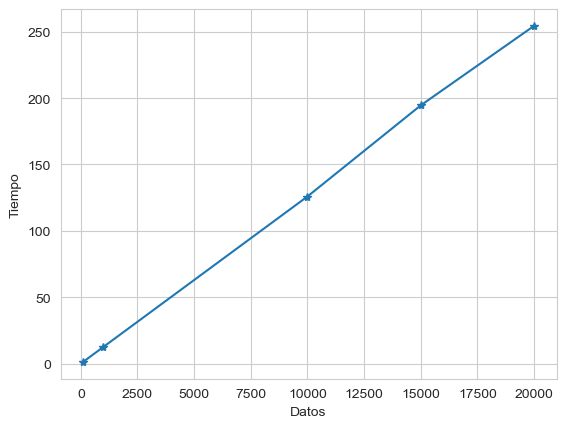

In [60]:
increase=data_tiempo
sns.set_style("whitegrid")
plt.plot(increase.cantidad, increase.tiempo, marker = '*', linestyle = '-')
plt.xlabel("Datos")
plt.ylabel("Tiempo")
plt.show()

### Análisis: 

-**La tendencia de la curva en relación a la ingesta de información (datos vs tiempo), indica un formato lineal.**


-**Por otra parte la tendencia de la curva en relación a volúmen de información (datos vs KB), indica un formato lineal, por lo que el escalamiento , dependería de la cantidad de storage en la máquina.** 

-**Por lo tanto la solución puede ser escalable, y depende del storage de la máquina.**



In [61]:
data_storate=pd.DataFrame()
data_storate = data_storate.append({'KB': 15,'datos':100},ignore_index=True)
data_storate = data_storate.append({'KB': 143,'datos':1000},ignore_index=True)
data_storate = data_storate.append({'KB': 1428,'datos':10000},ignore_index=True)
data_storate = data_storate.append({'KB': 2142,'datos':15000},ignore_index=True)
data_storate = data_storate.append({'KB': 2856,'datos':20000},ignore_index=True)

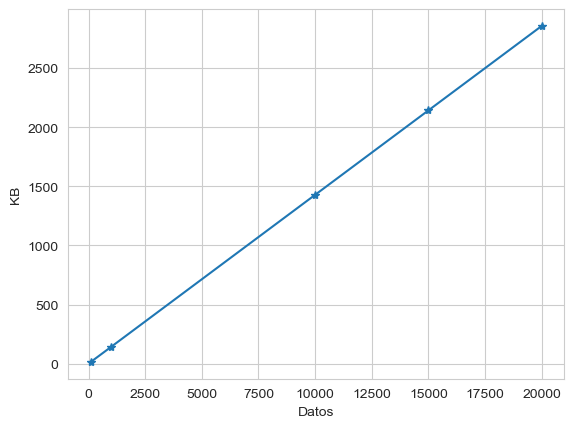

In [62]:
increase=data_storate
sns.set_style("whitegrid")
plt.plot(increase.datos, increase.KB, marker = '*', linestyle = '-')
plt.xlabel("Datos")
plt.ylabel("KB")
plt.show()

### 4. La solución debe estar escrita en Python usando una base de datos SQL

**R:OK**

### 5.-Puntos de bonificación si incluye su solución en contenedores y si dibuja cómo configuraría la aplicación en GCP

**R: Se crea una imagen de python, que contiene el servidor socket utilizado para consultar la automatización carga.**

**A continuación el paso a paso de la configuración en mi máquina local.**

**DOCKERFILE**

In [1172]:
# FROM python:3.8.4-slim-buster
# COPY . usr/src/app
# WORKDIR /usr/src/app
# RUN pip install -r requirements.txt
# ENTRYPOINT uvicorn --host 0.0.0.0 main:app --reload

**SERVER SOCKET DOCKER**

In [1171]:
# C:\Users\Usuario\Documents\POSTULACIONES\NeuralNetwork\docker_server>pip install -r requirements.txt
# Collecting fastapi==0.59.0
#   Downloading fastapi-0.59.0-py3-none-any.whl (49 kB)
#      |████████████████████████████████| 49 kB 51 kB/s
# Collecting uvicorn==0.11.5
#   Downloading uvicorn-0.11.5-py3-none-any.whl (43 kB)
#      |████████████████████████████████| 43 kB 113 kB/s
# Collecting pydantic<2.0.0,>=0.32.2
#   Downloading pydantic-1.10.4-cp39-cp39-win_amd64.whl (2.1 MB)
#      |████████████████████████████████| 2.1 MB 172 kB/s
# Collecting starlette==0.13.4
#   Downloading starlette-0.13.4-py3-none-any.whl (59 kB)
#      |████████████████████████████████| 59 kB 1.8 MB/s
# Collecting h11<0.10,>=0.8
#   Downloading h11-0.9.0-py2.py3-none-any.whl (53 kB)
#      |████████████████████████████████| 53 kB 739 kB/s
# Collecting click==7.*
#   Downloading click-7.1.2-py2.py3-none-any.whl (82 kB)
#      |████████████████████████████████| 82 kB 61 kB/s
# Collecting websockets==8.*
#   Downloading websockets-8.1.tar.gz (58 kB)
#      |████████████████████████████████| 58 kB 143 kB/s
# Collecting typing-extensions>=4.2.0
#   Downloading typing_extensions-4.4.0-py3-none-any.whl (26 kB)
# Using legacy 'setup.py install' for websockets, since package 'wheel' is not installed.
# Installing collected packages: typing-extensions, pydantic, starlette, fastapi, h11, click, websockets, uvicorn
#     Running setup.py install for websockets ... done
# Successfully installed click-7.1.2 fastapi-0.59.0 h11-0.9.0 pydantic-1.10.4 starlette-0.13.4 typing-extensions-4.4.0 uvicorn-0.11.5 websockets-8.1
# WARNING: You are using pip version 20.2.3; however, version 22.3.1 is available.
# You should consider upgrading via the 'c:\users\usuario\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.

# C:\Users\Usuario\Documents\POSTULACIONES\NeuralNetwork\docker_server>

**SERVER server.py**

In [1173]:
# # archivo main.py
# from fastapi import FastAPI
# # first of all import the socket library
# import socket			
# import os

# app = FastAPI()
# @app.get("/")
# def read_root():
# 	# next create a socket object
# 	s = socket.socket()		
# 	print ("Socket successfully created")

# 	# reserve a port on your computer in our
# 	# case it is 12345 but it can be anything
# 	port = 123456			

# 	# Next bind to the port
# 	# we have not typed any ip in the ip field
# 	# instead we have inputted an empty string
# 	# this makes the server listen to requests
# 	# coming from other computers on the network
# 	s.bind(('', port))		
# 	print ("socket binded to %s" %(port))

# 	# put the socket into listening mode
# 	s.listen(5)	
# 	print ("socket is listening")		

# 	# a forever loop until we interrupt it or
# 	# an error occurs
# 	while True:

# 		# Establish connection with client.
# 		c, addr = s.accept()	
# 		print ('Got connection from', addr )

# 		# send a thank you message to the client. encoding to send byte type.
		
# 		if os.path.exists('trips.csv'):
# 			c.send('TRUE'.encode())
# 		else:
# 			c.send('FALSE'.encode())	
# 		# Close the connection with the client
# 		#c.close()

# 		# Breaking once connection closed
# 		#break

**CONSTRUCCIÓN IMÁGEN**

In [1174]:
# C:\Users\Usuario\Documents\POSTULACIONES\NeuralNetwork\docker_server>docker build -t server_app .
# [+] Building 148.2s (9/9) FINISHED
#  => [internal] load build definition from Dockerfile                                                                                                               0.2s
#  => => transferring dockerfile: 200B                                                                                                                               0.0s
#  => [internal] load .dockerignore                                                                                                                                  0.1s
#  => => transferring context: 2B                                                                                                                                    0.0s
#  => [internal] load metadata for docker.io/library/python:3.8.4-slim-buster                                                                                       27.3s
#  => [internal] load build context                                                                                                                                  0.1s
#  => => transferring context: 1.62kB                                                                                                                                0.0s
#  => [1/4] FROM docker.io/library/python:3.8.4-slim-buster@sha256:9a827faf80ac75c692525c67bc6cff0e6e4a4093e73ad2674d17584b0c645af8                                 88.9s
#  => => resolve docker.io/library/python:3.8.4-slim-buster@sha256:9a827faf80ac75c692525c67bc6cff0e6e4a4093e73ad2674d17584b0c645af8                                  0.0s
#  => => sha256:772edcebc68616d4ee1e93e94ad3a49cbddd1101dca978a8d757f012e54ae354 7.63kB / 7.63kB                                                                     0.0s
#  => => sha256:8559a31e96f442f2c7b6da49d6c84705f98a39d8be10b3f5f14821d0ee8417df 27.10MB / 27.10MB                                                                  83.6s
#  => => sha256:62e60f3ef11eb77464958fc8fed447414fe652a21fc69aea87038a02e05e6000 2.75MB / 2.75MB                                                                    37.7s
#  => => sha256:9a827faf80ac75c692525c67bc6cff0e6e4a4093e73ad2674d17584b0c645af8 1.86kB / 1.86kB                                                                     0.0s
#  => => sha256:1808973dca9e89569d6359e4691ff24b2415fa369d83018429ff9f80c33da12a 1.37kB / 1.37kB                                                                     0.0s
#  => => sha256:9fdbefb714f0ba0d9e735b1732dc7398672e7c3c3a6035a85b8b5dfec4a8e43f 22.13MB / 22.13MB                                                                  67.1s
#  => => sha256:dfec9a593ccf211b00a95a2a37d68488d08d535646e765f16f048f2578810d20 234B / 234B                                                                        41.3s
#  => => sha256:3a480d72194a337def45bc621be861b7226a093f903b50bfe6a9b34f945f1b20 2.39MB / 2.39MB                                                                    55.9s
#  => => extracting sha256:8559a31e96f442f2c7b6da49d6c84705f98a39d8be10b3f5f14821d0ee8417df                                                                          2.2s
#  => => extracting sha256:62e60f3ef11eb77464958fc8fed447414fe652a21fc69aea87038a02e05e6000                                                                          0.2s
#  => => extracting sha256:9fdbefb714f0ba0d9e735b1732dc7398672e7c3c3a6035a85b8b5dfec4a8e43f                                                                          1.4s
#  => => extracting sha256:dfec9a593ccf211b00a95a2a37d68488d08d535646e765f16f048f2578810d20                                                                          0.0s
#  => => extracting sha256:3a480d72194a337def45bc621be861b7226a093f903b50bfe6a9b34f945f1b20                                                                          0.3s
#  => [2/4] COPY . usr/src/app                                                                                                                                       0.7s
#  => [3/4] WORKDIR /usr/src/app                                                                                                                                     0.1s
#  => [4/4] RUN pip install -r requirements.txt                                                                                                                     30.3s
#  => exporting to image                                                                                                                                             0.5s
#  => => exporting layers                                                                                                                                            0.5s
#  => => writing image sha256:5435060149fb5a37ce4e16922b5928e8c46e4ceb1048808dde0d8b68e0463fec                                                                       0.0s
#  => => naming to docker.io/library/server_app                                                                                                                      0.0s

# Use 'docker scan' to run Snyk tests against images to find vulnerabilities and learn how to fix them

# C:\Users\Usuario\Documents\POSTULACIONES\NeuralNetwork\docker_server>

#docker run -it -p 8000:8000 -v $PWD:/usr/src/app simple_app

#Server_app	IN USE	latest	5435060149fb	5 minutes ago	214.22 MB

### Arquitectura GCP:


La recuperación de información a través de estaciones gps, indica que el proyecto esta orientado a una solución de tipo IoT.

A través de Google Cloud services, es posible adaptar nuestra solución on-premise, para de esta forma enviar datos de forma segura a través de Cloud IoT Core bajo protocolo MQTT.

Para esto una solución puede consistir:

  -Los datos pueden ser procesados en forma basada en eventos usando Firebase Cloud Functions. 

  -Estos almacenan sin procesar en BigQuery y actualizan el estado actual del dispositivo en Firebase Realtime Database . 

  -Luego, se puede acceder a los datos a través de DataStudio y a través de una aplicación web simple alojada en Firebase      Hosting 


**Ahora, para nuestro caso de pruebas, al tratarse de una arquitectura híbrica, habría modificar el modelo e inclurir:**

    -Cloud Storage regional para cargar archivos .csv.

    -App Engine para montar nuestro servicios cliente/servidor.
    
    -Una VM que aloje un volúmen para instancias SQLite.
    
    -Componentes de Dataflow.
    
    -Componentes Pub/Sub como centro de mensajes.
    
    
    
    
    
A continuación arquitectura IoT:
    




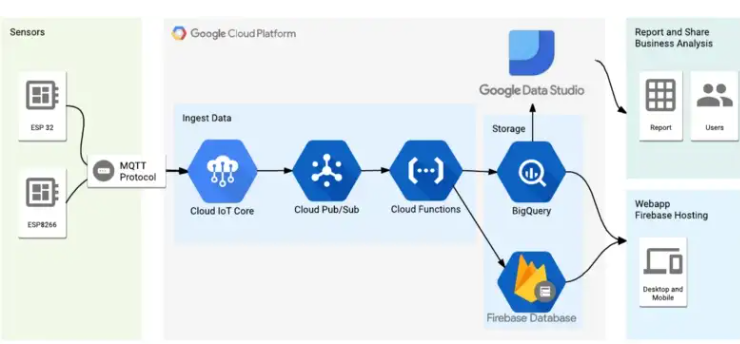